In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os as os
from os import environ
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="3"
from keras import utils
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation, Reshape, SpatialDropout2D, Activation
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.layers import MaxPooling2D, ZeroPadding2D, UpSampling2D, Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import PReLU, ELU
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, GlobalMaxPooling2D, SeparableConv2D
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.models import model_from_json
#import tensorflow as tf
from numpy import argmax


#from os.path import dirname, abspath
from os import listdir
from os.path import isfile, join
import numpy as np
from PIL import Image

import random as random
import cv2 as cv2

In [41]:
dim_x = dim_y = 224
part_one = "/home/leo/Classifier"
# part_one = "/Users/leonardomilea/Desktop/Fundus"
data_path = [part_one + "/Glaucoma/GITHUB", 
#              part one + "/Glaucoma/RUSSIA",
             part_one + "/Glaucoma/HRF",
             part_one+ "/Glaucoma/REFUGE",
             part_one+ "/Glaucoma/KAGGLE",
             part_one+ "/Healthy/GITHUB",
             part_one+ "/Healthy/Healthy11",
             part_one+ "/Healthy/KAGGLE"]
#              part one + "/Healthy/RUSSIA"]

In [4]:
#Increase distinction between channels on images 
def equalize(array):
    raw_img = (array).astype(np.uint8)
    raw_img_equalized = np.zeros_like(raw_img, dtype = np.float)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))  #for histogram equalization
    b,g,r = cv2.split(raw_img)
    raw_img_equalized[:,:,0] = clahe.apply(b) / 255.
    raw_img_equalized[:,:,1] = clahe.apply(g) / 255.
    raw_img_equalized[:,:,2] = clahe.apply(r) / 255.
    return raw_img_equalized

In [42]:
#extraction of training data
reload = True
if reload:
    segmentation_data = []
    glaucoma_data = []
    healthy_data = []
    for path_current in data_path:
        study = path_current.split("/")[-1]
        if path_current.split("/")[-2] == "Glaucoma":
            for f in listdir(path_current):
                if isfile(join(path_current, f)) and (f.endswith(".jpg") 
                                                            or f.endswith(".JPG") 
                                                            or f.endswith(".tif")
                                                            or f.endswith(".png")):
                    try:
                        image_raw = Image.open(join(path_current, f))
                        image_raw = image_raw.resize((dim_x, dim_y), Image.ANTIALIAS) #resize        
                        image_raw = np.array(image_raw) #transform to Numpy
                        if image_raw.shape == (224, 224, 3):
                            pass
                        elif image_raw.shape == (224,224):
                            reshaped_once = np.reshape(np.copy(image_raw), (224,224,1))
                            image_raw = np.repeat(reshaped_once, 3, axis = -1)
                        else:
                            print (image_raw.shape)
                        segmentation_data.append([equalize(image_raw), 1]) #Equalize the array - A glaucoma file has value 1
                        glaucoma_data.append(image_raw)
                    except:
                        pass
        elif path_current.split("/")[-2] == "Healthy":
            for f in listdir(path_current):
                if isfile(join(path_current, f)) and (f.endswith(".jpg") 
                                                            or f.endswith(".JPG") 
                                                            or f.endswith(".tif")
                                                            or f.endswith(".png")):
                    try:
                        image_raw = Image.open(join(path_current, f))
                        image_raw = image_raw.resize((dim_x, dim_y), Image.ANTIALIAS) #resize        
                        image_raw = np.array(image_raw) #transform to Numpy
                        if image_raw.shape == (224, 224, 3):
                            pass
                        elif image_raw.shape == (224,224):
                            reshaped_once = np.reshape(np.copy(image_raw), (224,224,1))
                            image_raw = np.repeat(reshaped_once, 3, axis = -1)
                        else:
                            print (image_raw.shape)
                        segmentation_data.append([equalize(image_raw), 0]) #Equalize the array - A healthy file has one hot encoding [0,1]
                    except:
                        pass

In [43]:
import keras.utils
#Save segmentation data as two lists: save_img_arrays, save_classification_arrays (as a one-hot encoded)
save_on_disk = True
if save_on_disk:
    save_img_arrays = np.zeros((len(segmentation_data), dim_x, dim_y, 3))
    save_classification_arrays = []
    for k in range (len (segmentation_data)):
        save_img_arrays[k,:,:,:] = np.copy(segmentation_data[k][0])
        save_classification_arrays.append(segmentation_data[k][1])
    save_classification_arrays = keras.utils.to_categorical(save_classification_arrays, num_classes=2, dtype='float32')
    np.save("img_arrays.npy", save_img_arrays)
    np.save("classification_arrays.npy", save_classification_arrays)

In [44]:
#Load segmentation data with save_classification_arrays as a one-hot encoded
load_from_disk = False
if load_from_disk:
    save_img_arrays = np.load("img_arrays.npy")
    save_classification_arrays = np.load("classification_arrays.npy")
    segmentation_data = []
    for k in range (save_img_arrays.shape[0]):
        segmentation_data.append([0,0])
    for k in range (save_img_arrays.shape[0]):
        segmentation_data[k][0] = np.copy(save_img_arrays[k,:,:,:])
        segmentation_data[k][1] = np.copy(save_classification_arrays[k,:])

In [45]:
#Shuffle the data so it isn't glaucoma followed by non-glaucoma
random.shuffle(segmentation_data)

In [46]:
# split train // test
# prepare X_train, Y_train, X_test, Y_test with one hot encoding
if not load_from_disk: #If segmentation_data hasn't been loaded
    n_total = len(segmentation_data)
    n_train = int(0.7 * n_total)  #70% are used as training data
    n_test = n_total - n_train
    Y_train, Y_test = [], []
    X_train = np.zeros((n_train, dim_x, dim_y, 3))
    X_test = np.zeros((n_test, dim_x, dim_y, 3))
    for k in range(n_train):
        X_train [k,:,:,:] = np.copy(segmentation_data[k][0])
        Y_train.append(segmentation_data[k][1])
    Y_train = keras.utils.to_categorical(Y_train, num_classes=2, dtype='float32')
    for k in range(n_test):
        X_test [(k),:,:,:] = np.copy(segmentation_data[k+n_train][0])
        Y_test.append(segmentation_data[k+n_train][1])
    Y_test = keras.utils.to_categorical(Y_test, num_classes=2, dtype='float32')
else: #If segmentation_data has been loaded
    n_total = len(segmentation_data)
    n_train = int(0.7 * n_total)  #70% are used as training data
    n_test = n_total - n_train
    Y_train, Y_test = np.zeros((n_train, 2)), np.zeros((n_test, 2))
    X_train = np.zeros((n_train, dim_x, dim_y, 3))
    X_test = np.zeros((n_test, dim_x, dim_y, 3))
    for k in range(n_train):
        X_train [k,:,:,:] = np.copy(segmentation_data[k][0])
        Y_train [k,:] = np.copy(segmentation_data[k][1])
    for k in range(n_test):
        X_test [k,:,:,:] = np.copy(segmentation_data[k+n_train][0])
        Y_test [k,:] = np.copy(segmentation_data[k+n_train][1])

In [47]:
#Create an evenly distributed test sample between glaucoma and healthy images for overfitting
test_data = []
k=0
while len(test_data)<50:
#     if np.argmax(segmentation_data[k][1]) == 0:
    if segmentation_data[k][1] == 0:
        test_data.append (segmentation_data[k])
    k+=1
while len(test_data)<100:
#     if np.argmax(segmentation_data[k][1]) == 1:
    if segmentation_data[k][1] == 1:
        test_data.append (segmentation_data[k])
    k+=1

In [48]:
#Shuffle the test_data
random.shuffle (test_data)

In [49]:
#Load the disk segmentation model
first_part = "/Users/leonardomilea"
first_part = "/home/leo/python/Classification/"
with open (first_part + "disk_model_newest.json", "r") as f:
    model = model_from_json(f.read())
model.load_weights(first_part+ "diskweights_newest.h5")

In [50]:
#Return disk segmentation model prediction of an image array
def prepare_seg (array):
    im = cv2.resize(array,(224,224))
    im = np.reshape(im, (1,224,224,3))
    im = K.variable(im)
    prediction = model.predict(im, steps = 1)
    prediction = np.reshape(prediction, (224,224,3))
    prediction = np.argmax(prediction, axis=2)
    return prediction

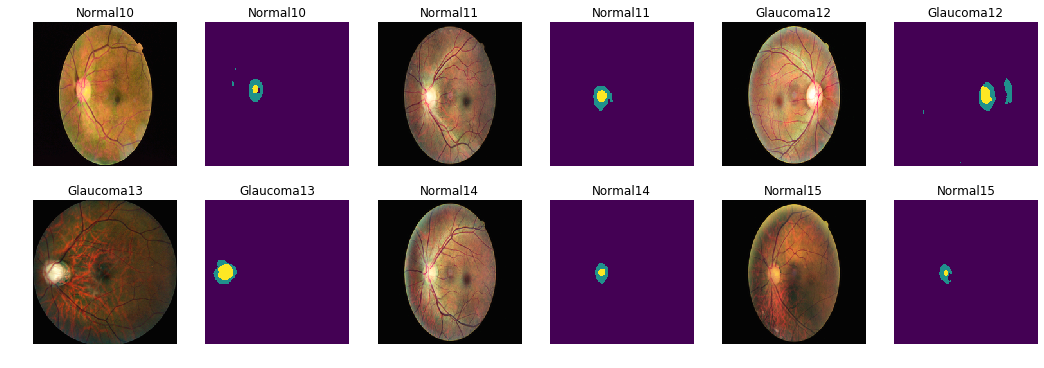

In [148]:
#DATA: sanity check for disk segmentation model
ncol = 3
nrow = 2
plt.rcParams['figure.figsize'] = (ncol*3*2, nrow*3)
offset = 300
for k in range(ncol*nrow):
    plt.subplot(nrow, ncol*2,2*k+1)
    j = k+10
    if test_data[j][1] == 1:
        title = "Glaucoma"
    else:
        title = "Normal"
    plt.title(title + str(j))
    plt.imshow(test_data[j][0])
    plt.axis("off")
for k in range(ncol*nrow):
    plt.subplot(nrow, ncol*2,2*k+2)
    j = k+10
    if test_data[j][1] == 1:
        title = "Glaucoma"
    else:
        title = "Normal"
    plt.title(title + str(j))
    plt.imshow(prepare_seg(test_data[j][0]))
    plt.axis("off")

In [135]:
#Return the area of the disk of the fundus img
def disk_area(img):
    disk_lst = []
    for x in range(224):
        for y in range (224):
            if img[x,y] ==2:
                disk_lst.append ([x,y])
    if len(disk_lst) == 0:
        for x in range(224):
            for y in range (224):
                if segmented_img[x,y] !=0:
                    disk_lst.append ([x,y])
    x_disk_lst, y_disk_lst = [],[]
    for coordinate in disk_lst:
        x_disk_lst.append(coordinate[0])
        y_disk_lst.append(coordinate[1])
    j,m = min(x_disk_lst)-20, min(y_disk_lst)-20
    x_list, y_list = [], []
    while j < max(x_disk_lst)+20:
        x_list.append(j)
        j+=1
    while m < max(y_disk_lst)+20:
        y_list.append(m)
        m+=1
    for y in y_list:
        for x in x_list:
            img[x,y] = 5
    return img

In [150]:
#Focus the fundus image on the disk only for segmented image
def remove_segmented_background(raw_img):
    all_coordinates = []
    disk_lst = []
    segmented_img = prepare_seg(raw_img)
    for x in range(224):
        for y in range (224):
            all_coordinates.append([x,y])
            if segmented_img[x,y] ==2:
                disk_lst.append ([x,y])
    if len(disk_lst) == 0:
        print ("using second way")
        for x in range(224):
            for y in range (224):
                if segmented_img[x,y] !=0:
                    disk_lst.append ([x,y])
    x_disk_lst, y_disk_lst = [],[]
    for coordinate in disk_lst:
        x_disk_lst.append(coordinate[0])
        y_disk_lst.append(coordinate[1])
    j,m = min(x_disk_lst)-15, min(y_disk_lst)-15
    x_list, y_list = [], []
    while j < max(x_disk_lst)+15:
        x_list.append(j)
        j+=1
    while m < max(y_disk_lst)+15:
        y_list.append(m)
        m+=1
    for y in y_list:
        for x in x_list:
            if [x,y] in all_coordinates:
                all_coordinates.remove([x,y])
    copy = np.zeros_like(segmented_img)
    copy = np.copy(segmented_img)
    for e in all_coordinates:
        copy[e[0],e[1]] = 0
    return copy

In [151]:
#Focus the fundus image on the disk only
def remove_background(raw_img):
    all_coordinates = []
    disk_lst = []
    segmented_img = prepare_seg(raw_img)
    for x in range(224):
        for y in range (224):
            all_coordinates.append([x,y])
            if segmented_img[x,y] ==2:
                disk_lst.append ([x,y])
    if len(disk_lst) == 0:
        for x in range(224):
            for y in range (224):
                if segmented_img[x,y] !=0:
                    disk_lst.append ([x,y])
    x_disk_lst, y_disk_lst = [],[]
    for coordinate in disk_lst:
        x_disk_lst.append(coordinate[0])
        y_disk_lst.append(coordinate[1])
    j,m = min(x_disk_lst)-30, min(y_disk_lst)-30
    x_list, y_list = [], []
    while j < max(x_disk_lst)+30:
        x_list.append(j)
        j+=1
    while m < max(y_disk_lst)+30:
        y_list.append(m)
        m+=1
    for y in y_list:
        for x in x_list:
            if [x,y] in all_coordinates:
                all_coordinates.remove([x,y])
    copy = np.zeros_like(raw_img)
    copy = np.copy(raw_img)
    for e in all_coordinates:
        copy[e[0],e[1], :] = 0
    return copy

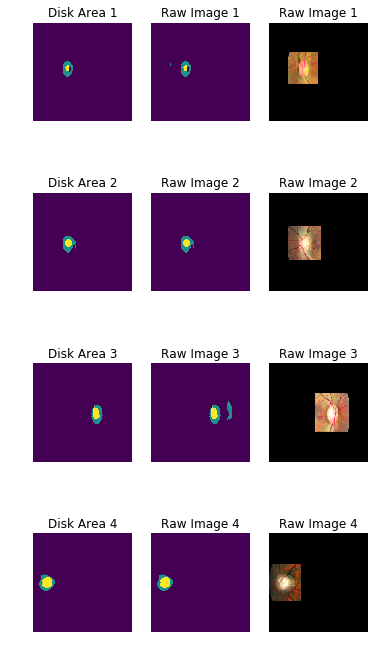

In [152]:
#DATA: sanity check
ncol = 1
nrow = 4
plt.rcParams['figure.figsize'] = (ncol*3*2, nrow*3)
offset = 300
for k in range(ncol*nrow):
    plt.subplot(nrow, ncol*3,3*k+1)
    plt.imshow(remove_segmented_background(test_data[k+10][0]))
    plt.title("Disk Area " + str(k+1))
    plt.axis("off")
    
    plt.subplot(nrow, ncol*3,3*k+2)
    plt.imshow(prepare_seg(test_data[k+10][0]))
    plt.title("Raw Image " + str(k+1))
    plt.axis("off")

    plt.subplot(nrow, ncol*3,3*k+3)
    plt.imshow(remove_background(test_data[k+10][0]))
    plt.title("Raw Image " + str(k+1))
    plt.axis("off")

In [20]:
n_total = len(test_data)
n_train = int(0.7 * n_total)  #70% are used as training data
n_test = n_total - n_train
Y_train, Y_test = np.zeros((n_train, 2)), np.zeros((n_test, 2))
X_train = np.zeros((n_train, dim_x, dim_y, 3))
X_test = np.zeros((n_test, dim_x, dim_y, 3))
for k in range(n_train):
    X_train [k,:,:,:] = np.copy(test_data[k][0])
    Y_train [k,:] = np.copy(test_data[k][1])
for k in range(n_test):
    X_test [k,:,:,:] = np.copy(test_data[k+n_train][0])
    Y_test [k,:] = np.copy(test_data[k+n_train][1])

In [21]:
#Build Sequential Model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(224,224,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [22]:
#Compile Model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False),
              metrics=['accuracy'])

In [ ]:
tfit_history = model.fit(X_train, Y_train,
          batch_size=8,
          epochs=10,
          verbose=1,
          validation_data=(X_test, Y_test))

In [23]:
#Plot the epoch progression
plt.rcParams['figure.figsize'] = (10,5)
plt.plot(fit_history.history["loss"], "b-s", label="training_loss")
plt.plot(fit_history.history["val_loss"], "r-s", label="validation loss")
plt.legend()
plt.title("Losses")
plt.xlabel("Epoch")
plt.grid(True)

NameError: name 'fit_history' is not defined